In [126]:
import pandas as pd
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%config InlineBackend.figure_format='retina'


In [28]:
y = np.random.uniform(size=1000)
y = (y > 0.2).astype(int)

yhat = np.random.uniform(size=1000)
yhat = (yhat > 0.2).astype(int)


In [242]:
def _score(
    preds,
    targets,
    threshold: float,
) -> pd.DataFrame:

    pred_tops = preds >= 1 - threshold
    pred_bottoms = preds < threshold

    target_tops = targets >= 1 - threshold
    target_bottoms = targets < threshold

    target_values = np.random.normal(loc=0, scale=10, size=len(targets)) * targets

    tp: int = (target_tops & pred_tops).sum()
    fp: int = (target_bottoms & pred_tops).sum()
    tn: int = (target_bottoms & pred_bottoms).sum()
    fn: int = (target_tops & pred_bottoms).sum()

    top_financial = target_values[pred_tops].sum()
    bottom_financial = -target_values[pred_bottoms].sum()
    financial = top_financial + bottom_financial

    precision = safe_divide(tp, tp + fp)
    recall = safe_divide(tp, tp + fn)
    f1 = safe_divide(2 * (precision * recall), precision + recall)
    accuracy = safe_divide(tp + tn, tp + tn + fp + fn)

    tp_norm = safe_divide(tp, target_tops.sum())
    tn_norm = safe_divide(tn, target_bottoms.sum())
    fp_norm = safe_divide(fp, target_bottoms.sum())
    fn_norm = safe_divide(fn, target_tops.sum())

    res = pd.DataFrame(
        {
            'threshold': threshold,
            'tp': tp_norm,
            'tn': tn_norm,
            'fp': fp_norm,
            'fn': fn_norm,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'financial': financial
        },
        index=[0],
    )
    return res


def safe_divide(numerator, denominator) -> float:
    return numerator / denominator if denominator != 0 else 0


In [238]:
def compute_metrics(y, yhat):
    return pd.DataFrame({
        'mae': sklearn.metrics.mean_absolute_error(y, yhat),
        'mse': sklearn.metrics.mean_squared_error(y, yhat),
        'accuracy': sklearn.metrics.accuracy_score(y, yhat),
        'precision': sklearn.metrics.precision_score(y, yhat, zero_division=0),
        'recall': sklearn.metrics.recall_score(y, yhat),
        'f1': sklearn.metrics.f1_score(y, yhat),
        # 'financial': ((y == yhat) & (yhat == 1)).sum()
    }, index=[0])

In [61]:
y = np.array([
    1,1,0,0,0,
    0,0,0,0,0
])

In [62]:
yhat = np.array([
    0,0,0,0,0,
    0,0,0,0,0
])
compute_metrics(y, yhat)

,mae,mse,accuracy,precision,recall,f1,financial
0,0.2,0.2,0.8,0.0,0.0,0.0,0


In [65]:
yhat = np.array([
    1,0,0,0,0,
    0,0,0,0,0
])
compute_metrics(y, yhat)

,mae,mse,accuracy,precision,recall,f1,financial
0,0.1,0.1,0.9,1.0,0.5,0.666667,1


In [66]:
yhat = np.array([
    1,1,1,0,0,
    0,0,0,0,0
])
compute_metrics(y, yhat)

,mae,mse,accuracy,precision,recall,f1,financial
0,0.1,0.1,0.9,0.666667,1.0,0.8,2


In [67]:
yhat = np.array([
    1,1,0,0,0,
    0,0,0,0,0
])
compute_metrics(y, yhat)

,mae,mse,accuracy,precision,recall,f1,financial
0,0.0,0.0,1.0,1.0,1.0,1.0,2


In [137]:
def generate_data(ptrue_0_class=0.9, p_noise=1, ppred_0_class=0.5, N=1000):
    # Generate ground truth 
    y = np.random.uniform(size=N)
    y = (y > ptrue_0_class).astype(int)

    # Generate predictions
    _weight = np.random.uniform(size=N)
    noise = np.random.uniform(size=N) < ppred_0_class
    yhat = np.where(_weight <  p_noise, noise, y)

    return pd.DataFrame({'y': y, 'yhat': yhat})

In [138]:
results = []
for p_noise in np.arange(1, 0, -0.01):
    df = generate_data(ptrue_0_class=0.9, p_noise=p_noise, ppred_0_class=0)
    results.append(compute_metrics(df.y, df.yhat))
df_final = pd.concat(results)

Text(0.5, 1.0, 'Financial Performance vs F1')

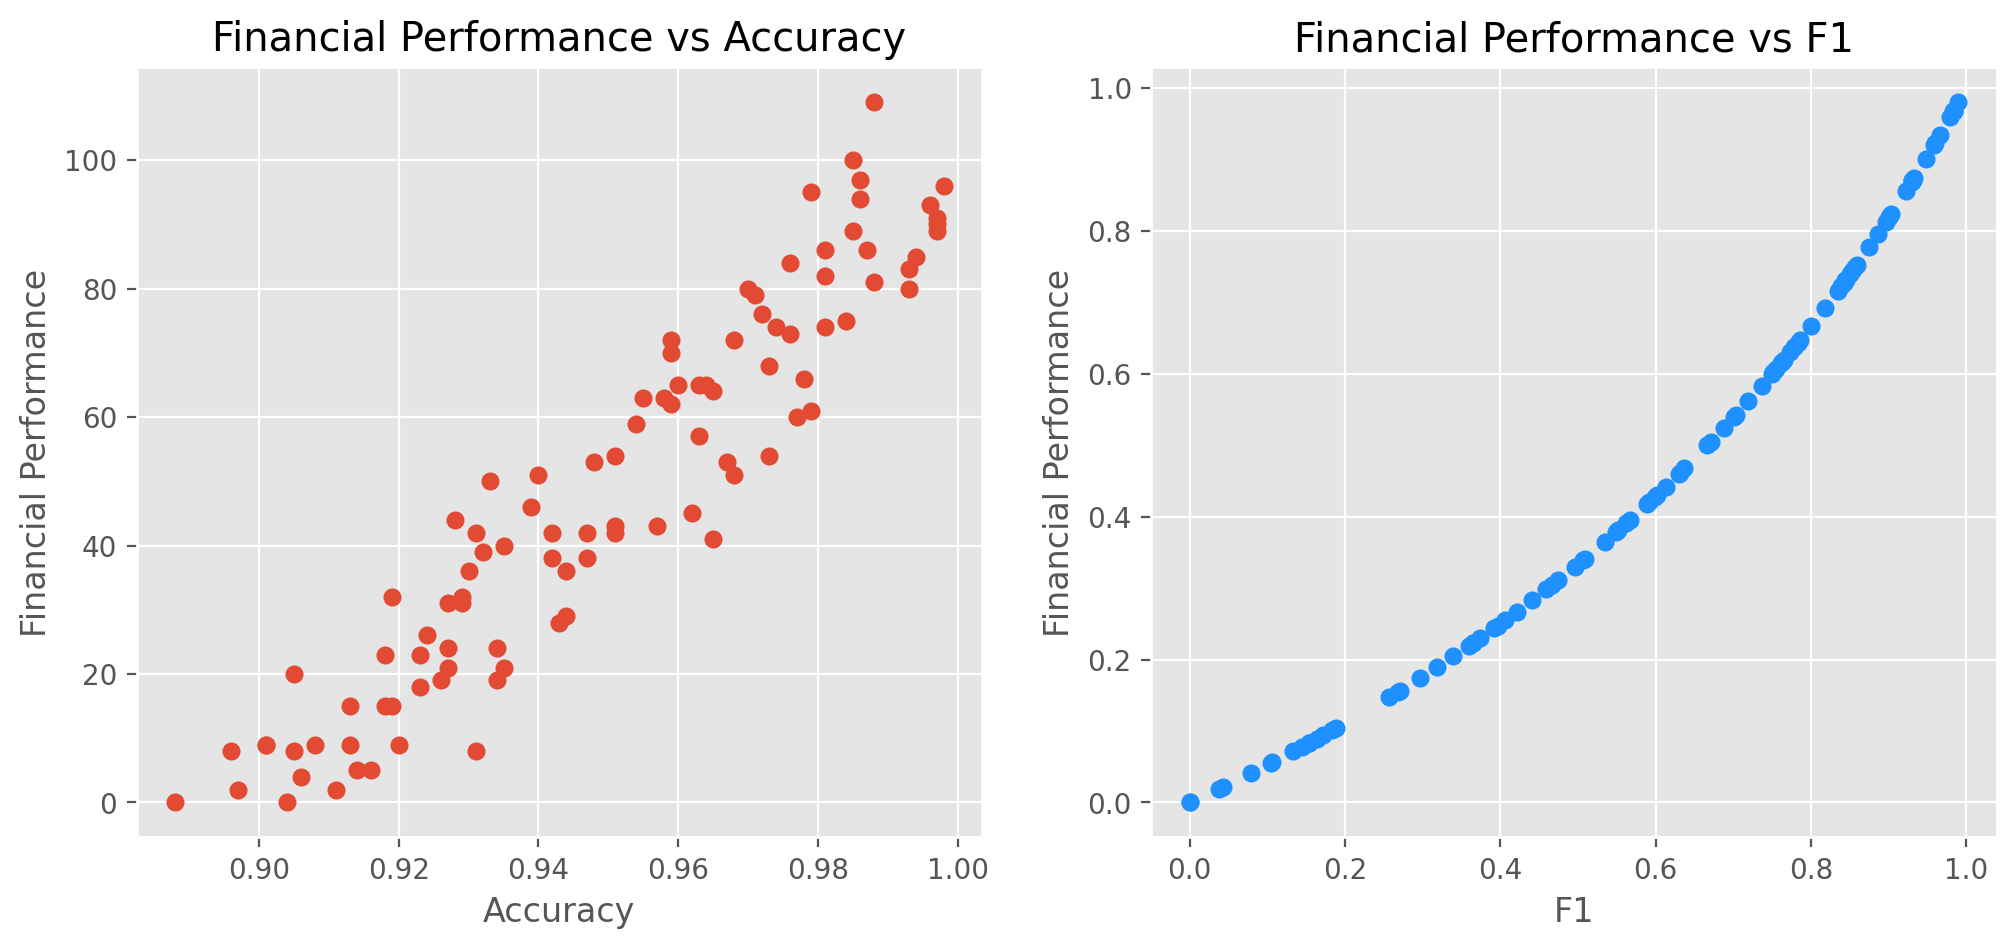

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df_final.accuracy, df_final.financial)
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Financial Performance')
ax1.set_title('Financial Performance vs Accuracy')

ax2.scatter(df_final.f1, df_final.recall, color='dodgerblue')
ax2.set_xlabel('F1')
ax2.set_ylabel('Financial Performance')
ax2.set_title('Financial Performance vs F1')

In [147]:
_score(df.y, df.yhat, threshold=0.1)

,threshold,tp,tn,fp,fn,precision,recall,f1,accuracy
0,0.1,1.0,0.9967,0.0033,0.0,0.968085,1.0,0.983784,0.997


# New data generating process

In [243]:
def _threshold_y(y, threshold):
    return np.select(
        [y < threshold, y > 1 - threshold],
        [-1, 1],
        0
    )


def generate_data(pnoise=0.5, N=1000):
    # Generate ground truth 
    y = np.random.uniform(size=N)

    # Generate predictions
    _weight = np.random.uniform(size=N)
    noisy_ypred = np.random.uniform(size=N)
    yhat = np.where(_weight <  pnoise, noisy_ypred, y)

    return pd.DataFrame({'y': y, 'yhat': yhat})

In [244]:
results = []
for p_noise in np.arange(1, 0, -0.01):
    df = generate_data(pnoise=p_noise, N=10_000)
    tmp = _score(df.y, df.yhat, threshold=0.2)
    # tmp = tmp.assign(financial=(tmp.tp - tmp.fp) * np.random.normal(5, 10))
    results.append(tmp)
df_final = pd.concat(results)

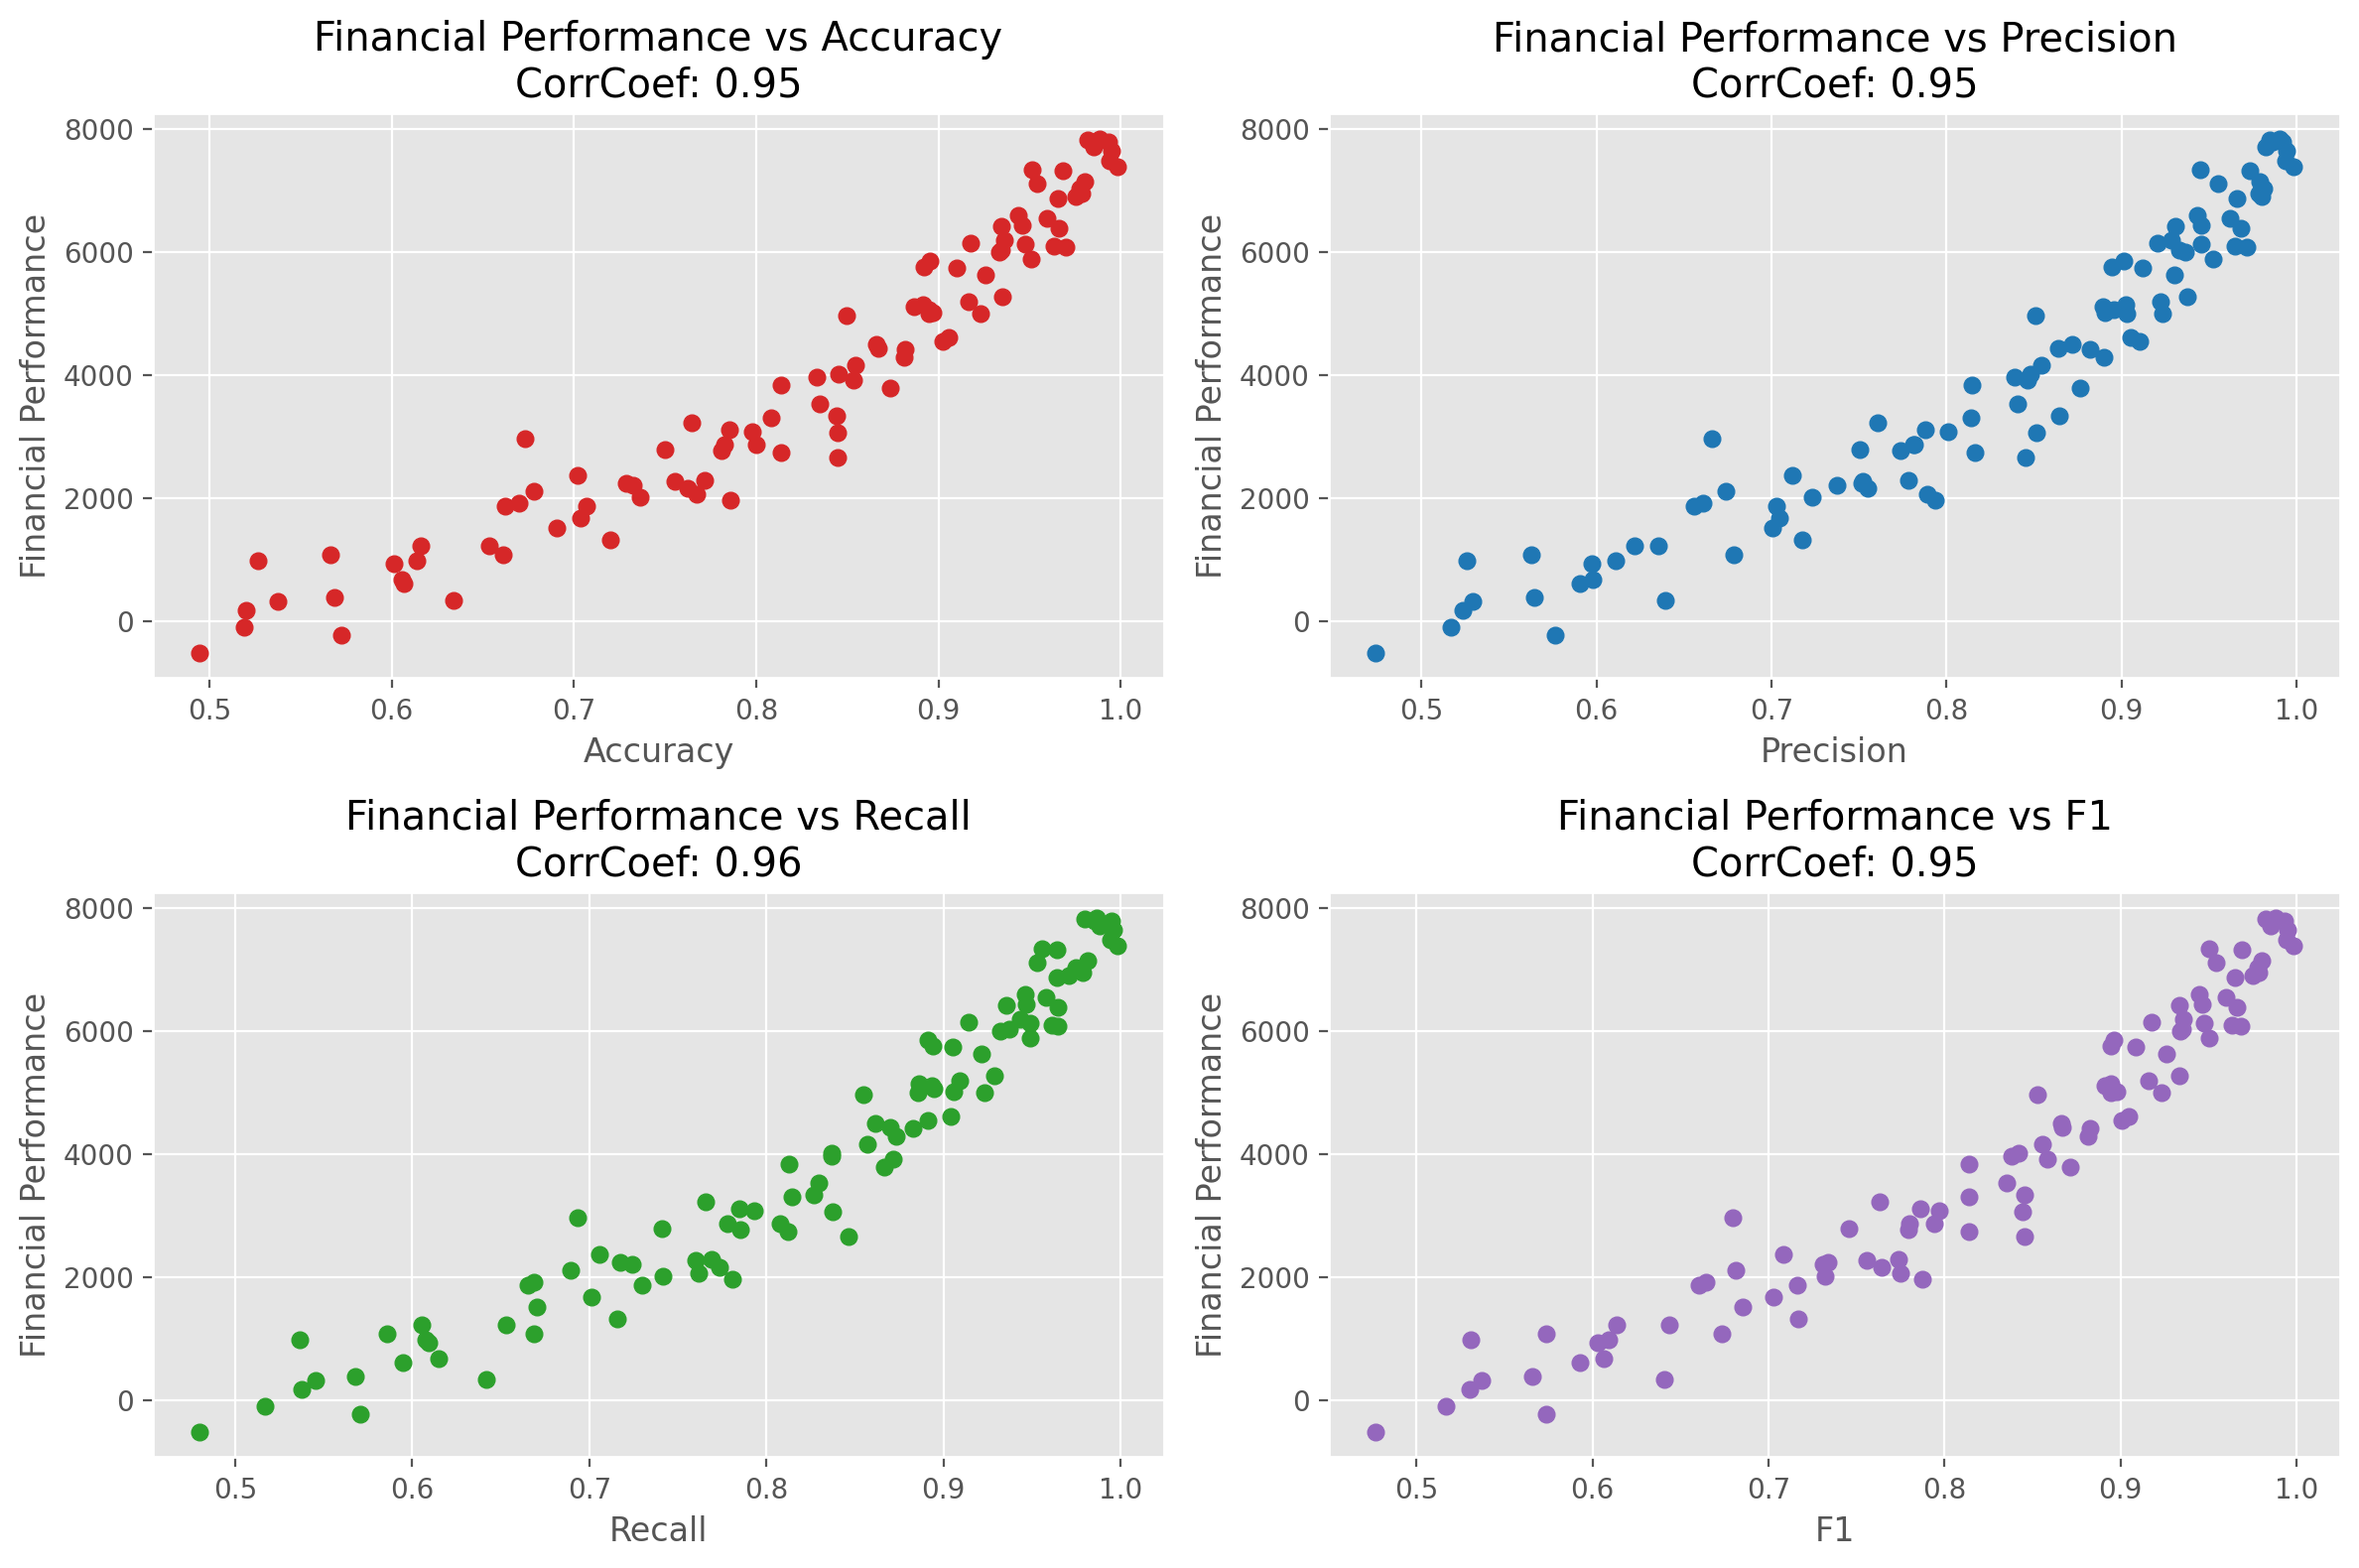

In [245]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.scatter(df_final.accuracy, df_final.financial, color='tab:red')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Financial Performance')
ax1.set_title(f'Financial Performance vs Accuracy\nCorrCoef: {round(np.corrcoef(df_final.accuracy, df_final.financial)[0][1], 2)}')

ax2.scatter(df_final.precision, df_final.financial, color='tab:blue')
ax2.set_xlabel('Precision')
ax2.set_ylabel('Financial Performance')
ax2.set_title(f'Financial Performance vs Precision\nCorrCoef: {round(np.corrcoef(df_final.precision, df_final.financial)[0][1], 2)}')

ax3.scatter(df_final.recall, df_final.financial, color='tab:green')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Financial Performance')
ax3.set_title(f'Financial Performance vs Recall\nCorrCoef: {round(np.corrcoef(df_final.recall, df_final.financial)[0][1], 2)}')

ax4.scatter(df_final.f1, df_final.financial, color='tab:purple')
ax4.set_xlabel('F1')
ax4.set_ylabel('Financial Performance')
ax4.set_title(f'Financial Performance vs F1\nCorrCoef: {round(np.corrcoef(df_final.f1, df_final.financial)[0][1], 2)}')

plt.tight_layout()

In [246]:
np.corrcoef(df_final.accuracy, df_final.financial)[0][1]

0.9549299701492051

In [200]:
np.corrcoef(df_final.f1, df_final.financial)

array([[1.       , 0.8706669],
       [0.8706669, 1.       ]])